In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os
import csv
import datetime as d
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import time
import math
import scipy
from scipy import stats
import scipy.stats as st
from scipy.stats import norm
import seaborn as sns
import mpmath

#### Intialization & data ingestion

In [6]:
M_t=41*7+5#length of data
filenum=42 
cluster_num=5
#M_norm is the processed mobility matrix, and density and dwell are the degree of congestion and dwell time, respectively, for the five categories of places in the 42 uhf
data_path='/Location of data/'
M_norm = np.loadtxt(data_path+'M.txt', delimiter = ',').reshape((M_t,42,42*cluster_num))
density=np.loadtxt(data_path+'density.txt', delimiter = ',').reshape((filenum,42*cluster_num))
dwell=np.loadtxt(data_path+'dwell.txt', delimiter = ',').reshape((filenum,42*cluster_num))

# Table of weeks corresponding to dates
f = open(data_path+'dict_day2week.txt','r')
a = f.read()
day2week= eval(a)
f.close()

# New York City Population by UHF
N_raw=pd.read_excel(data_path+'NYCpop.xlsx',usecols=['num'],dtype='int')
N_all=N_raw.values

# New York City Simulated Infection and UHF Simulated Infection Data
uhf_real_case=np.loadtxt(data_path+'uhf_sim_obs.txt', delimiter = ',').reshape((14,42))
NYC_real_case=np.loadtxt(data_path+'NYC_sim_obs.txt')
uhf_name=pd.read_excel(data_path+'uhf_info.xlsx',usecols=['UHF_name'],dtype='str')

# Artificially simulated daily detection rate
sim_raw=pd.read_excel(data_path+"sim_obs.xlsx",dtype='float')
sim_daily_rate=sim_raw.values

#Timeframe for calculating likelihood
date_scale=np.zeros((42,2),dtype=int)
for j in range(42):
    u=uhf_real_case[:14,j]
    umax=np.max(u)
    v=np.argwhere(u>0.2*umax)
    date_scale[j][0]=int(v[0])
    date_scale[j][1]=int(v[-1])

# Parameter settings
Z=3.59
D=3.56
a=0.5
b=0.5
sam_num=1000 
para_num=cluster_num+1
sim_t1=103
aver_delay=14
#Ratio of E and I in the initial value
EIfactor=5
# Number of MCMC trainings
n1=30000
seed_0=1200 #Initial assumption of total NYC infections
s_factor=np.array([0.0077804 , 0.02339975, 0.03096405,0.03509373, 0.020644  ,
       0.0248404 , 0.01729817, 0.02062146, 0.02336571, 0.03521075,
       0.01557102, 0.00760455, 0.06664087, 0.03892939, 0.0254785 ,
       0.01601171, 0.03034952, 0.02062874, 0.02491628, 0.02035715,
       0.01355837, 0.02436521, 0.02877314, 0.02579249, 0.01574011,
       0.01093734, 0.02100978, 0.00591962, 0.02110973, 0.08461017,
       0.01597016, 0.00724917, 0.03076374, 0.01372457, 0.03013459,
       0.03678055, 0.02433973, 0.02106431, 0.00654353, 0.01393221,
       0.01296151, 0.02901384])
seed=seed_0*s_factor#Initial assumption of infections for UHF

#delay model
x = np.arange(0.0, 21, 1) 
y1 = st.gamma.pdf(x, 1.85, scale=aver_delay/1.85)
raw=np.array([y1[i+1] for i in range(20)])
prob_gamma=(raw/np.sum(raw)).reshape(20,1)

#Climate weights
humudity_raw=pd.read_csv(data_path+'NY_humudity.csv')
humudity=humudity_raw[56:56+M_t].values#start at 2.26
R_max=2.7
R_min=1.2
hum=(np.exp(-180*humudity+np.log(R_max-R_min))+R_min)/D
hum_factor=hum/np.mean(hum)

### Function

In [8]:
def SEIR_count(currState,currM,infFor,Z,D,betaBase,season_factor):#SEIR
    newState=np.zeros((4,42))
    newcase=np.zeros(42)
    flag=0
    delta_S=currState[0]*((currM.dot(season_factor*infFor)).T)+season_factor*betaBase*currState[0]*currState[2]/(N_all.T)
    test=currState[0]-delta_S
    newState[0] = test
    newState[1] = currState[1]+delta_S-currState[1]/Z
    newState[2] =currState[2]+currState[1]/Z-currState[2]/D
    newcase=currState[1]/Z
    newState[3] = currState[3]+currState[2]/D
    if np.min(newState)<0:      
        flag=1               
    return newState,newcase,flag

def GetLambda(I,N,v_set,a,b,currdensity,currdwell):#Calculate the force of infection at different sites at the current week
    mylambda=np.zeros((42*cluster_num))
    repeat_v=np.tile(v_set,(1,42))
    partial=I/N
    mylambda=repeat_v*partial*(currdensity**a)*(currdwell**b)
    return mylambda.T


def getStart(seed,factor):#Initialize each UHF state variable
    StateStart=np.zeros((4,42))
    for i in range(42):
        s=seed[i]
        StateStart[2][i]=random.uniform(max(s-5,1),s+5)
        StateStart[1][i]=factor*StateStart[2][i]
        StateStart[3][i]=0
        StateStart[0][i]=N_all[i]-StateStart[1][i]-StateStart[2][i]-StateStart[3][i]
    return  StateStart 

def segmented_simulation(para,t1,t2,wnum,uhf_start,statestart,startcase):#Simulate the number of infections under the current parameters
    State=np.zeros((t2-t1+1,4,42))
    State[0]=statestart
    v_set=para[0:5]
    beta=para[5]
    flag=0
    uhf_daily_obs=np.zeros(((t2-t1+1,42)))
    uhf_week_obs=np.zeros(((wnum,42)))
    new_case=startcase.copy()
    for t in range(1,t2-t1+1):
        real_t=t1+t
        deltacase=np.zeros(42)
        I_set=State[t-1][2].dot(M_norm[real_t-1])
        N_set=(N_all.T).dot(M_norm[real_t-1])
        infFor=GetLambda(I_set,N_set,v_set,a,b,density[day2week[real_t-1]],dwell[day2week[real_t-1]])
        State[t],deltacase,flag=SEIR_count(State[t-1],M_norm[real_t-1],infFor,Z,D,beta,hum_factor[real_t-1])
        if flag==0:#delay model
            deltacase=deltacase.reshape(1,42)
            prob_case=prob_gamma.dot(deltacase)
            new_case[real_t:min(real_t+20,t2-t1+1)]+=prob_case[:min(t2-t1+1-real_t,20)]
    uhf_daily_obs=sim_daily_rate[t1:t2]*new_case[t1:t2]
    sum_daily_obs=np.sum(uhf_daily_obs,axis=1)
    uhf_week_obs=np.sum(uhf_daily_obs[uhf_start:uhf_start+7*wnum].reshape((wnum,7,42)),axis=1)
    return flag,uhf_week_obs,sum_daily_obs,State[-1],new_case

def GetUHFLogLikelihood(real_uhf,uhf_obs,weekstart):#Calculate the log-likelihood
    loguhflikelihood=0
    if weekstart==0:
        for i in range(42):
            likelihood=scipy.stats.norm.pdf(real_uhf[date_scale[i][0]:date_scale[i][1]+1,i],loc=uhf_obs[date_scale[i][0]:date_scale[i][1]+1,i],scale=100+0.5*uhf_obs[date_scale[i][0]:date_scale[i][1]+1,i])
            likelihood[likelihood==0]=0.0000001
            loguhflikelihood+=np.sum(np.log(likelihood))
    else:
        likelihood=scipy.stats.norm.pdf(real_uhf,loc=uhf_obs,scale=100+0.5*uhf_obs)
        likelihood[likelihood==0]=0.0000001
        loguhflikelihood=np.sum(np.log(likelihood))       
        
    return loguhflikelihood

def MH_step(para_index,para_set,curr_real_case,p_scale,weekstart,weeknum,t1,t2,uhf_start,statestart,casestart,reject_factor):
    if para_index<5:
        step=5
    else:
        step=0.01
    prior_p=para_set[para_index]
    pos_uhf_case=np.zeros((weeknum,42))
    pri_uhf_case=np.zeros((weeknum,42))
    pri_cell=segmented_simulation(para_set,t1,t2,weeknum,uhf_start,statestart,casestart)
    pri_uhf_case=pri_cell[1]
    pri_log_prob=GetUHFLogLikelihood(curr_real_case,pri_uhf_case,weekstart)
    new_para_set=para_set.copy()
    repeat_num=0
    choice_flag=0
    while True:
        repeat_num+=1
        if repeat_num<100:
            post_p=np.random.normal(loc=prior_p,scale=step)#Random generation of a posteriori parameters
            if post_p >p_scale[0] and post_p < p_scale[1]:
                new_para_set[para_index]=post_p
                iter_cell=segmented_simulation(new_para_set,t1,t2,weeknum,uhf_start,statestart,casestart)
                if iter_cell[0]==0:
                    pos_uhf_case=iter_cell[1]
                    pos_log_prob=GetUHFLogLikelihood(curr_real_case,pos_uhf_case,weekstart)
                    break 
        else:
            choice_flag=1
            break
    if choice_flag==0:#Determine whether to accept a new parameter based on the log likelihood
        u=mpmath.exp(pos_log_prob-pri_log_prob)
        if u>1 or np.random.uniform(0,1)<reject_factor*u:
            return post_p,1
        else:
            return prior_p,0
    else:#Unreasonable parameters
        return prior_p,2


In [9]:
def getMCMC(para_start,weekstart,weeknum,t1,t2,uhf_start,statestart,casestart,rej_fac,n_mcmc,para_scale):
    para_record=np.zeros((n_mcmc+1,para_num))
    para_record[0]=para_start
    stady_set=np.zeros((sam_num,para_num))
    recept_flag=0
    valid_flag=1
    for i in range(n_mcmc-1):
        para_record[i+1]=para_record[i]
        if valid_flag==1:
            for j in range(para_num):#One perturbation per parameter
                para_record[i+1][j],recept_flag=MH_step(j,para_record[i+1],uhf_real_case[weekstart:weekstart+weeknum],para_scale[j],weekstart,weeknum,t1,t2,uhf_start,statestart,casestart,rej_fac)
                if recept_flag==2:
                    valid_flag=0
                    break
        else:
            break
    #parameter sampling
    if valid_flag==1:
        stady_set=np.array([para_record[-10000+10*k1] for k1 in range(sam_num)])
    #Getting the best parameters
    error_set=np.zeros(sam_num)
    uhfState_set=np.zeros((sam_num,4,42))
    case_set=np.zeros((sam_num,sim_t1,42))
    for i in range(sam_num):
        uhf_obs,_,uhfState_set[i],case_set[i]=segmented_simulation(stady_set[i],t1,t2,weeknum,uhf_start,statestart,casestart)[1:]
        error_set[i]=np.mean(abs(uhf_real_case[weekstart:weekstart+weeknum]-uhf_obs))
  
    best_sample_id=np.argmin(error_set)
    para_new=stady_set[best_sample_id]
    best_sample_endstate=uhfState_set[best_sample_id]
    best_sample_case=case_set[best_sample_id]
    return para_new,para_record,best_sample_endstate,best_sample_case

### MAIN

In [10]:
para_scale=np.array([[10,40],[3,15],[10,40],[10,40],[10, 40],[0.005,0.025]])
para_0=np.array([28,5 ,28, 20 ,22,0.012])#initial value of a parameter

state0=getStart(seed,EIfactor)
case0=np.zeros((sim_t1,42)) 
                                     
para_1,para_record,state1,case1=getMCMC(para_0,0,14,1,sim_t1,4,state0,case0,0.3,n1,para_scale)


### Plotting the best parameter fit

In [11]:
def seed_sample(seed,factor):#Fluctuating initial seeds and the ratio of E to I
    StateStart=np.zeros((4,42))
    for i in range(42):
        s=seed[i]
        StateStart[2][i]=random.uniform(0.9*s,1.1*s)
        StateStart[1][i]=factor*StateStart[2][i]
        StateStart[3][i]=random.uniform(10,100)
        StateStart[0][i]=N_all[i]-StateStart[1][i]-StateStart[2][i]-StateStart[3][i]
    return  StateStart 

def combine_simulation(T,t1,state0,p1,wnum):#Simulation of propagation
    state=np.zeros((T,4,42))
    state[0]=state0
    case=np.zeros((T,42))
    uhf_daily_obs=np.zeros(((T,42)))
    uhf_week_obs=np.zeros(((wnum,42)))
    for t in range(1,t1):
        beta=p1[-1]
        v_set=p1[:5]
        deltacase=np.zeros(42)
        I_set=state[t-1][2].dot(M_norm[t-1])
        N_set=(N_all.T).dot(M_norm[t-1])
        infFor=GetLambda(I_set,N_set,v_set,a,b,density[day2week[t-1]],dwell[day2week[t-1]])
        state[t],deltacase,flag=SEIR_count(state[t-1],M_norm[t-1],infFor,Z,D,beta,hum_factor[t-1])
        if flag==0:
            deltacase=deltacase.reshape(1,42)
            prob_case=prob_gamma.dot(deltacase)
            case[t:min(t+20,T)]+=prob_case[:min(T-t,20)]        
    uhf_daily_obs=sim_daily_rate[:T]*case
    com_sim_daily_case=np.sum(uhf_daily_obs,axis=1)
    uhf_week_obs=np.sum(uhf_daily_obs[4:-1].reshape((wnum,7,42)),axis=1)
    return com_sim_daily_case,uhf_week_obs

free_num=100# Number of free simulation samples
case_record=np.zeros((free_num,sim_t1))
state_sim=np.zeros((free_num,4,42))
uhf_record=np.zeros((free_num,14,42))
for i in range(free_num):
    State0=np.zeros((4,42))
    seed_sim=random.uniform(1000,2000)*s_factor
    State0=seed_sample(seed_sim,random.uniform(1,5))
    state_sim[i]=State0
    result=combine_simulation(sim_t1,sim_t1,State0,para_1,14)
    case_record[i]=result[0]
    uhf_record[i]=result[1]
   
NYC_mean=np.mean(case_record,axis=0)

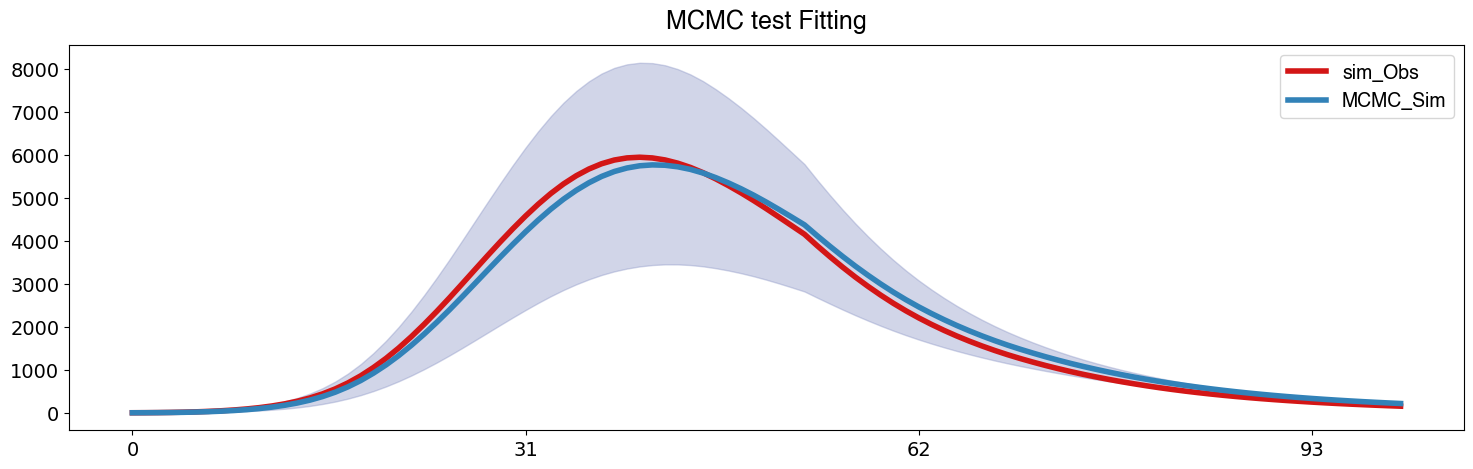

In [13]:
# Plotting basic and mean curves
x=np.arange(101)
hex_colors=['#D31616','#3282B8','#F6C90E','#137C00','#8c96c6']
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(x,NYC_real_case[1:],color=hex_colors[0], linewidth=4)
ax.plot(x,NYC_mean[1:-1],color=hex_colors[1], linewidth=4)

#95%CI
lower=np.array([np.percentile(case_record[:,i+1], 2.5) for i in range(len(NYC_real_case[1:]))])
upper=np.array([np.percentile(case_record[:,i+1], 97.5) for i in range(len(NYC_real_case[1:]))])
plt.fill_between(x,lower, upper, interpolate=True, color=hex_colors[4], alpha=0.4)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(31))
plt.setp(plt.gca().get_xticklabels(),rotation=0)
text_font = {'family': 'Helvetica', 'size': 14}
plt.legend(labels=['sim_Obs','MCMC_Sim'],prop=text_font )#'case-by-day'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MCMC test Fitting',loc='center', fontweight='bold', pad=12, fontsize=18)
plt.show()


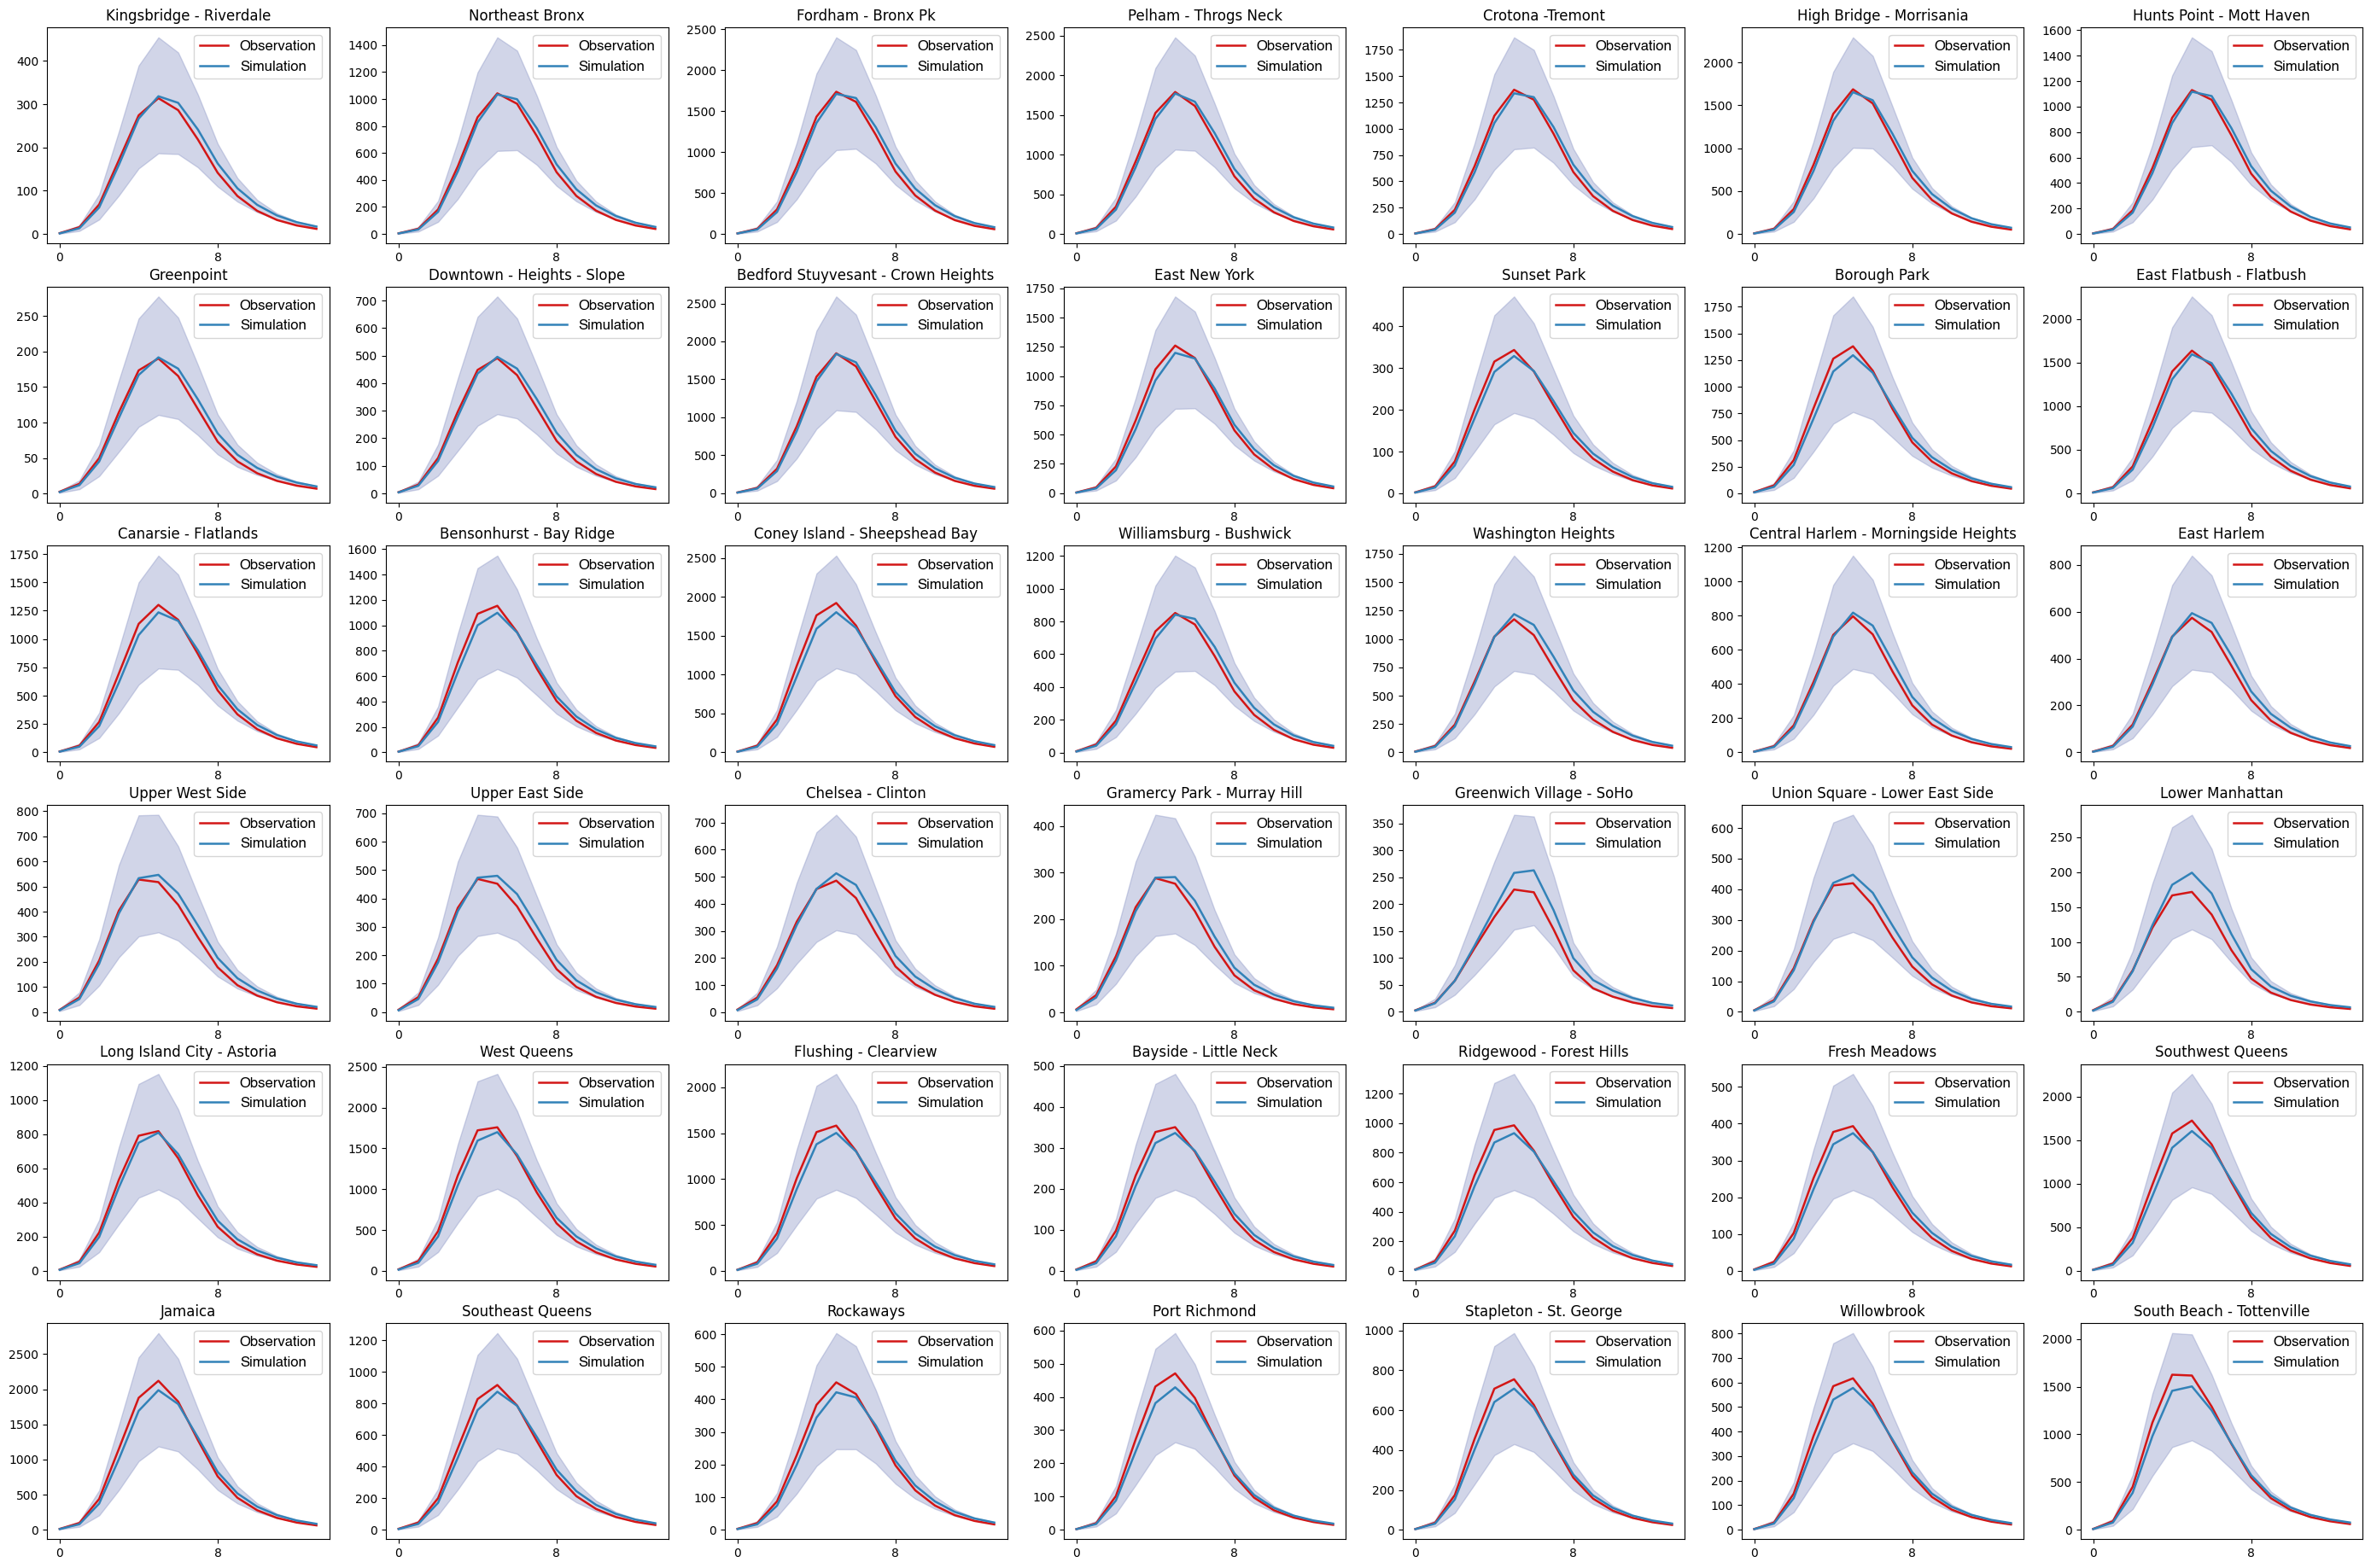

In [14]:
text_font2 = {'family': 'Helvetica', 'size': 12}
fig=plt.figure(figsize=(35,23)) 

xticksig = np.arange(14).astype(dtype=str)
for j in range(42):
    ax=plt.subplot(6,7,j+1)
    ax.plot(xticksig,uhf_real_case[:,j],color=hex_colors[0], linewidth=1.8) 
    plt.title(uhf_name['UHF_name'][j])
    uhf_mean=np.mean(uhf_record[:,:,j],axis=0)
    ax.plot(xticksig,uhf_mean,color=hex_colors[1], linewidth=1.8)
    lower=np.array([np.percentile(uhf_record[:,i,j], 2.5) for i in range(len(uhf_mean))])
    upper=np.array([np.percentile(uhf_record[:,i,j], 97.5) for i in range(len(uhf_mean))])
    plt.legend(labels=['Observation','Simulation'],prop=text_font2 )
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(8))
    plt.fill_between(xticksig,lower, upper, interpolate=True, color=hex_colors[4], alpha=0.4)
plt.show()